In [1]:
from math import sqrt, log10
import numpy as np
import drjit as dr
import matplotlib.pyplot as plt

# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

from sionna.rt import LambertianPattern, DirectivePattern, BackscatteringPattern,\
                      load_scene, Camera, Transmitter, Receiver, PlanarArray,\
                      PathSolver, RadioMapSolver, cpx_abs, cpx_convert

no_preview = True # Toggle to False to use the preview widget
                  # instead of rendering for scene visualization

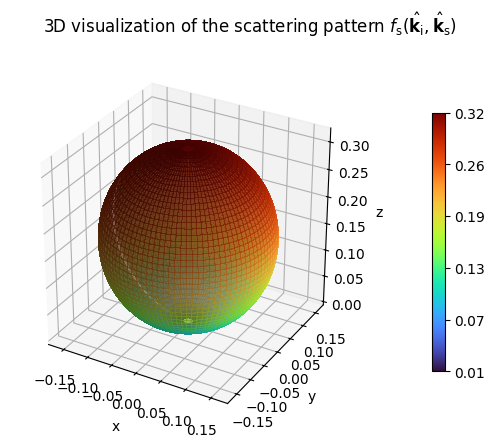

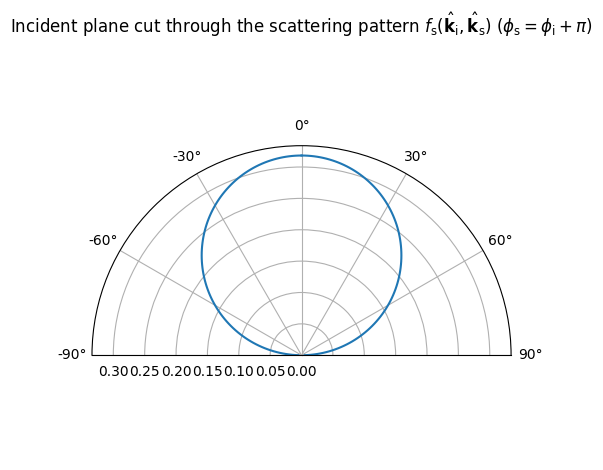

In [2]:
LambertianPattern().show();

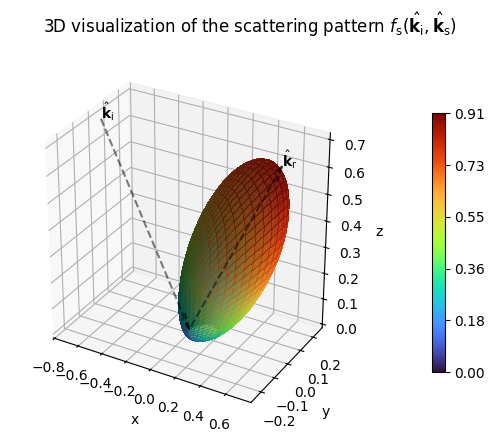

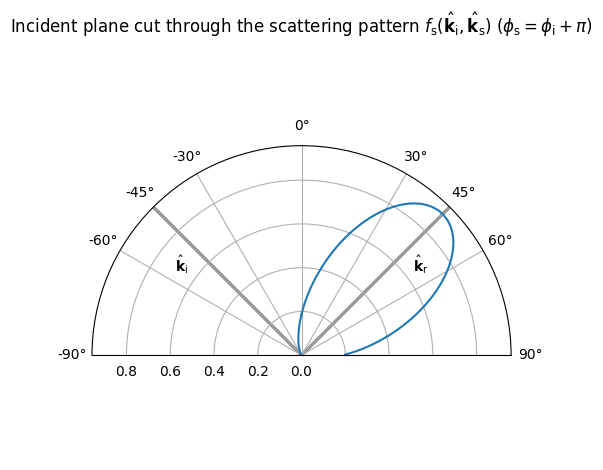

In [3]:
# The stronger alpha_r, the more the pattern
# is concentrated around the specular direction.
DirectivePattern(alpha_r=10).show(show_directions=True);

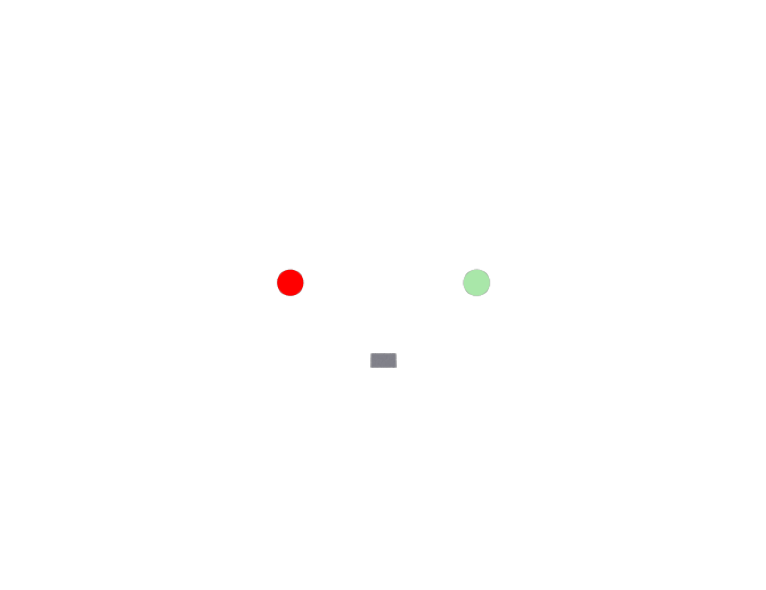

In [4]:
scene = load_scene(sionna.rt.scene.simple_reflector, merge_shapes=False)

# Configure the transmitter and receiver arrays
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

scene.rx_array = scene.tx_array

# Add a transmitter and receiver with equal distance from the center of the surface
# at an angle of 45 degrees.
dist = 5
d = dist/sqrt(2)
scene.add(Transmitter(name="tx", position=[-d,0,d]))
scene.add(Receiver(name="rx", position=[d,0,d]))

if no_preview:
    # Add a camera for visualization
    my_cam = Camera(position=[0, -30, 20], look_at=[0,0,3])
    scene.render(camera=my_cam, num_samples=128)
else:
    scene.preview()

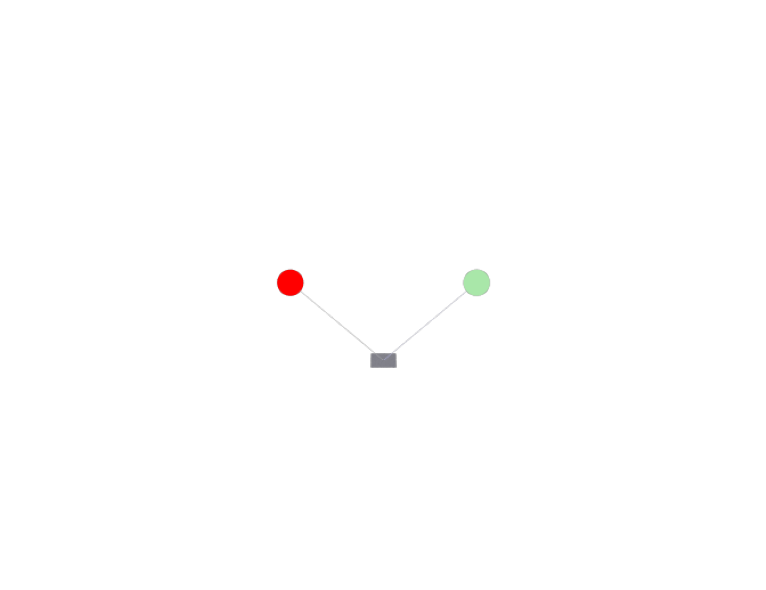

In [5]:
p_solver = PathSolver()
paths = p_solver(scene=scene, los=False, specular_reflection=True)

if no_preview:
    scene.render(camera=my_cam, paths=paths);
else:
    scene.preview(paths=paths)

In [6]:
paths = p_solver(scene=scene, los=False, specular_reflection=False, diffuse_reflection=True)
print(paths.a)

([[[[[]]]]], [[[[[]]]]])


In [7]:
scene.get("reflector").radio_material.scattering_coefficient = 0.5
paths = p_solver(scene=scene, los=False, specular_reflection=False,
                 diffuse_reflection=True, samples_per_src=10**6)
print(f"There are {paths.a[0].shape[-1]} scattered paths.")


There are 2252 scattered paths.


In [8]:
paths = p_solver(scene=scene, los=False, specular_reflection=False,
                 diffuse_reflection=True, samples_per_src=2*10**6)
print(f"There are {paths.a[0].shape[-1]} scattered paths.")

There are 4506 scattered paths.


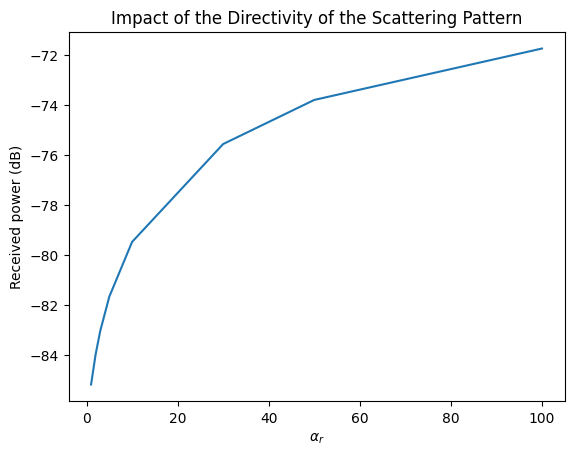

In [9]:
scattering_pattern = DirectivePattern(1)
scene.get("reflector").radio_material.scattering_pattern = scattering_pattern
alpha_rs =[1,2,3,5,10,30,50,100]
received_powers = []
for alpha_r in alpha_rs:
    scattering_pattern.alpha_r = alpha_r
    paths = p_solver(scene=scene, los=False, specular_reflection=False, diffuse_reflection=True)
    received_powers.append(10*log10(dr.sum(cpx_abs(paths.a)**2).numpy()))

plt.figure()
plt.plot(alpha_rs, received_powers)
plt.xlabel(r"$\alpha_r$")
plt.ylabel("Received power (dB)");
plt.title("Impact of the Directivity of the Scattering Pattern");

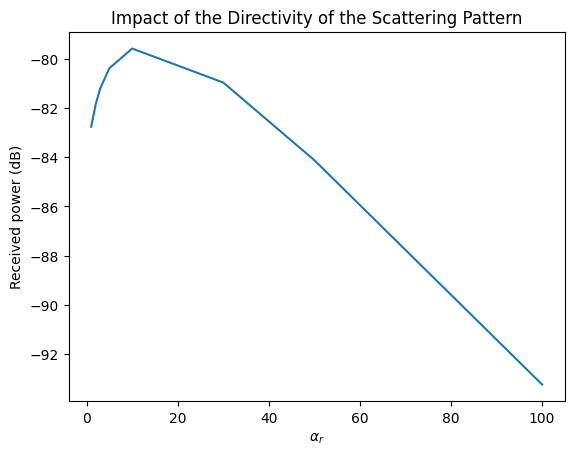

In [10]:
# Move the receiver closer to the surface, i.e., away from the specular angle theta=45deg
scene.get("rx").position = [d, 0, 1]
received_powers = []
for alpha_r in alpha_rs:
    scattering_pattern.alpha_r = alpha_r
    paths = p_solver(scene=scene, los=False, specular_reflection=False, diffuse_reflection=True)
    received_powers.append(10*log10(dr.sum(cpx_abs(paths.a)**2).numpy()))

plt.figure()
plt.plot(alpha_rs, received_powers)
plt.xlabel(r"$\alpha_r$")
plt.ylabel("Received power (dB)");
plt.title("Impact of the Directivity of the Scattering Pattern");

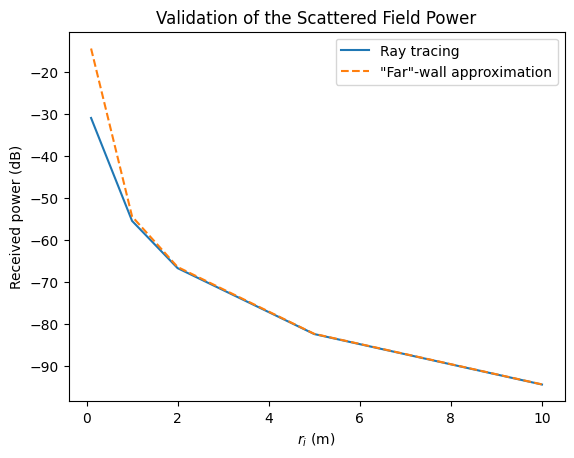

In [11]:
s = 0.7 # Scattering coefficient

# Configure the radio material
scene.get("reflector").radio_material.scattering_pattern = LambertianPattern()
scene.get("reflector").radio_material.scattering_coefficient = s

# Set the carrier frequency
scene.frequency = 3.5e9
wavelength = scene.wavelength

r_is = [0.1, 1, 2, 5, 10] # Varying distances
received_powers = []
theo_powers = []
for r_i in r_is:
    # Update the positions of TX and RX
    d = r_i/sqrt(2)
    scene.get("tx").position = [-d, 0, d]
    scene.get("rx").position = [d, 0, d]
    paths = p_solver(scene=scene, los=False, specular_reflection=False, diffuse_reflection=True)
    received_powers.append(10*log10(dr.sum(cpx_abs(paths.a)**2).numpy()))

    # Compute theoretically received power using the far-wall approximation
    theo_powers.append(10*log10((wavelength[0]*s/(4*dr.pi*r_i**2))**2/(2*dr.pi)))

plt.figure()
plt.plot(r_is, received_powers)
plt.plot(r_is, theo_powers, "--")
plt.title("Validation of the Scattered Field Power")
plt.xlabel(r"$r_i$ (m)")
plt.ylabel("Received power (dB)");
plt.legend(["Ray tracing", "\"Far\"-wall approximation"]);

In [12]:
scene = load_scene(sionna.rt.scene.simple_street_canyon)
scene.frequency = 30e9
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

scene.rx_array = scene.tx_array
scene.add(Transmitter(name="tx",
                      position=[-33,11,32],
                      orientation=[0,0,0]))

# We add a receiver for later path computations
scene.add(Receiver(name="rx",
                      position=[27,-13,1.5],
                      orientation=[0,0,0]))


my_cam = Camera(position=[10,0,300], look_at=[0,0,0])
my_cam.look_at([0,0,0])

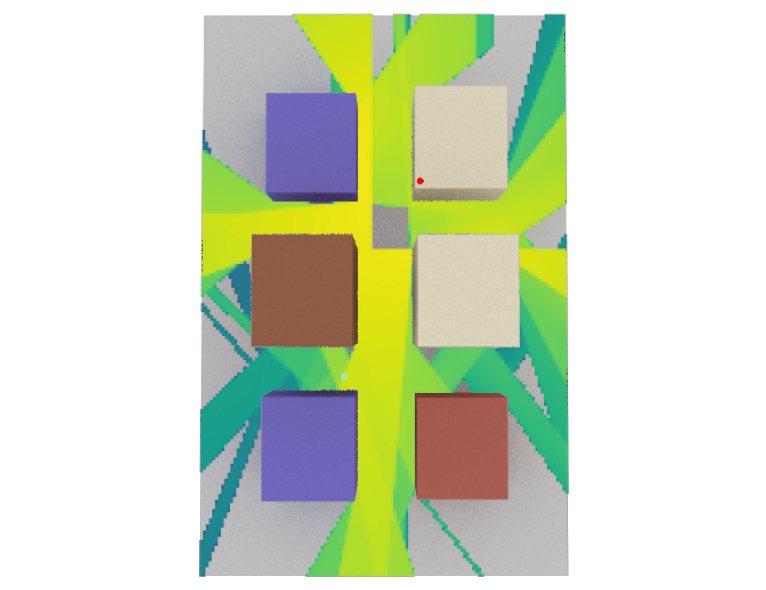

In [13]:
rm_solver = RadioMapSolver()
rm = rm_solver(scene, cell_size=[1,1], samples_per_tx=int(20e6), max_depth=5, refraction=False)
if no_preview:
    scene.render(camera=my_cam, radio_map=rm, rm_vmin=-200, rm_vmax=-90);
else:
    scene.preview(radio_map=rm, rm_vmin=-200, rm_vmax=-90);

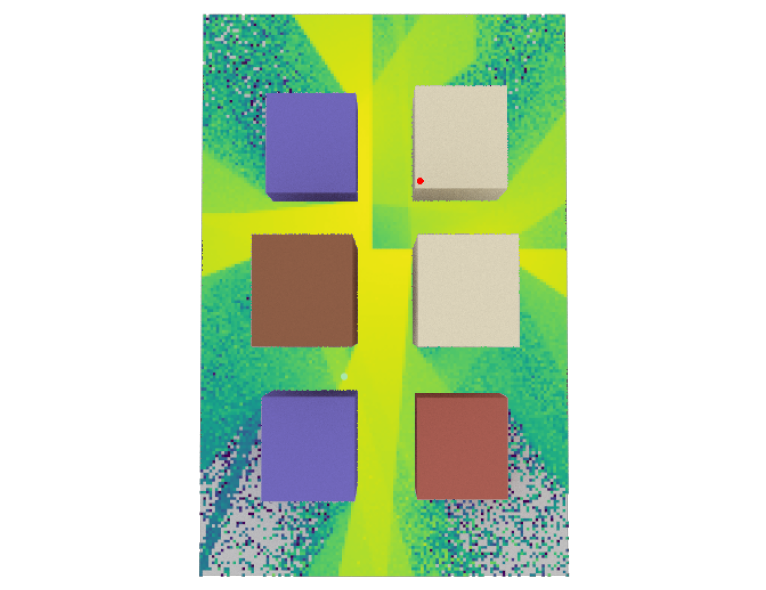

In [14]:
# Configure radio materials for scattering
# By default the scattering coefficient is set to zero
for rm in scene.radio_materials.values():
    rm.scattering_coefficient = 1/sqrt(3) # Try different values in [0,1]
    rm.scattering_pattern = DirectivePattern(alpha_r=10) # Play around with different values of alpha_r

rm_scat = rm_solver(scene, cell_size=[1,1], samples_per_tx=int(20e6), max_depth=5,
                    refraction=False, diffuse_reflection=True)

if no_preview:
    scene.render(camera=my_cam, radio_map=rm_scat, rm_vmin=-200, rm_vmax=-90);
else:
    scene.preview(radio_map=rm_scat, rm_vmin=-200, rm_vmax=-90);

<Figure size 640x480 with 0 Axes>

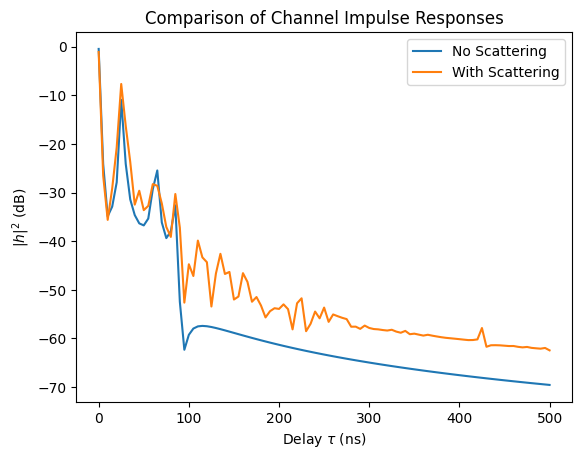

In [15]:
# Change the scattering coefficient of all radio materials
for rm in scene.radio_materials.values():
    rm.scattering_coefficient = 1/sqrt(3)

bandwidth=200e6 # bandwidth of the receiver (= sampling frequency)

plt.figure()

# Paths without diffuse reflections
paths = p_solver(scene,
                 max_depth=5,
                 samples_per_src=10**6,
                 diffuse_reflection=False,
                 refraction=False,
                 synthetic_array=True)

# Paths with diffuse reflections
paths_diff = p_solver(scene,
                 max_depth=5,
                 samples_per_src=10**6,
                 diffuse_reflection=True,
                 refraction=False,
                 synthetic_array=True)

# Compute channel taps without scattering
taps = paths.taps(bandwidth, l_min=0, l_max=100, normalize=True, out_type="numpy")
taps = np.squeeze(taps)
tau = np.arange(taps.shape[0])/bandwidth*1e9

# Compute channel taps wit scattering
taps_diff = paths_diff.taps(bandwidth, l_min=0, l_max=100, normalize=True, out_type="numpy")
taps_diff = np.squeeze(taps_diff)

# Plot results
plt.figure();
plt.plot(tau, 20*np.log10(np.abs(taps)));
plt.plot(tau, 20*np.log10(np.abs(taps_diff)));
plt.xlabel(r"Delay $\tau$ (ns)");
plt.ylabel(r"$|h|^2$ (dB)");
plt.title("Comparison of Channel Impulse Responses");
plt.legend(["No Scattering", "With Scattering"]);